# Monitor climate change over Europe with land reanalysis data

Reanalysis - trend assessment and bias - climate monitoring -
Production date: 01 - 07- 2024

# Are the monthly averaged temperature data from ERA5-Land suitable for recovering the trend of annual mean temperature increase in Spain in order to monitor climate change?

ERA5-Land dataset contains global reanalysis data with different level of aggregation: hourly and monthly average. One of the most analyzed variable provided is the "2m temperature". Temperature data are important to assess climatology and trends for climate change analysis. Study the climatology is becoming a topic always more essential to study for the increasing temperature due to global warming (https://www.ipcc.ch/sr15/). In this use case, we want to check the feasibility of using directly ERA5-Land monthly averaged data to compute the average annual temperature trend at country level. We will focus on Spain considering the total length of data series available. To validate the analysis, we will compare it to the climatology statistical provided by Statistic Research Service, https://climateknowledgeportal.worldbank.org/country/spain/climate-data-historical.

## Quality assessment statement

We suggest that ERA5-Land generally reproduces the temperature trend very well for observations. Comparison with in-situ data from the Climate Knowledge Portal  [[1]](https://climateknowledgeportal.worldbank.org/country/spain/climate-data-historical), shows an increasing trend in mean annual temperature for Spain. Our analysis using ERA5-Land data  also indicate a statistically significant increasing trend in the annual mean temperature for Spain, with values that are consistent with observed data.
However, there is a bias in the ERA5-Land data, which tends to underestimate the annual mean temperature, particularly before 2015. These results are consistent with findings in the literature, such as those reported by Zhao P and He Z (2022) [[2]](https://www.frontiersin.org/journals/earth-science/articles/10.3389/feart.2022.907730/full)).


## Methodology

- Download 't2m' temperature variable (K) selecting the boundary box area of Iberian Peninsula
- Choose years of analysis: here we selected from 1997 to 2022
- Cut the map selecting Spain
- Calculate the average annual temperature for the entire area
- Changing units of measure from Kelvin to Celsius
- Barplot grouped for year with annual temperature values
- Comparison with in-situ data
- Trend and significance with Mann Kendall Test

## Analysis and results

## Import packages

Import c3s_eqc_automatic_quality_control library and packages to calculate the statistics.

In [1]:
import cartopy.crs as ccrs
import fsspec
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymannkendall as mk
import shapely.geometry
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot

plt.style.use("seaborn-v0_8-notebook")

## Set variables for request

Set the starting and ending year of analysis.

In [2]:
# Time
year_start = 1997
year_stop = 2022

# External files
shapefile_url = "https://www.eea.europa.eu/data-and-maps/data/eea-reference-grids-2/gis-files/spain-shapefile/at_download/file"
observed_csv = (
    "observed-annual-average-mean-surface-air-temperature-of-spain-for-1901-2022.csv"
)

## Set the data request

Select the request, specifying the type of variable (monthly averaged reanalysis), variable (2m temperature) and the latitude and longitude coordinates for the Iberian Peninsula.

In [3]:
collection_id = "reanalysis-era5-land-monthly-means"
request = {
    "product_type": "monthly_averaged_reanalysis",
    "variable": "2m_temperature",
    "year": [str(year) for year in range(year_start, year_stop + 1)],
    "month": [f"{month:02d}" for month in range(1, 12 + 1)],
    "time": "00:00",
    "area": [44, -10, 36, 0],
}

## Download data and convert to Celsius

Download considering 1 year chuncks.

In [4]:
ds = download.download_and_transform(collection_id, request, chunks={"year": 1})
da = ds["t2m"]
with xr.set_options(keep_attrs=True):
    da -= 273.15
da.attrs["units"] = "°C"

100%|██████████| 26/26 [00:01<00:00, 14.74it/s]


## Select and cut Spain map

Cut the map with Spain shapefile

In [5]:
def clip_shapefile(data, shapefile_url):
    shapefile_crs = "EPSG:4326"
    with fsspec.open(f"simplecache::{shapefile_url}") as file:
        gdf = gpd.read_file(file, layer="es_100km").to_crs(shapefile_crs)

    data = data.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")
    data = data.rio.write_crs(shapefile_crs)
    data_clip = data.rio.clip(
        gdf.geometry.apply(shapely.geometry.mapping), gdf.crs, drop=False
    )
    return data_clip


da = clip_shapefile(da, shapefile_url)

## Plot annual mean

Evaluation of the spatial annual mean and plot of the curve.

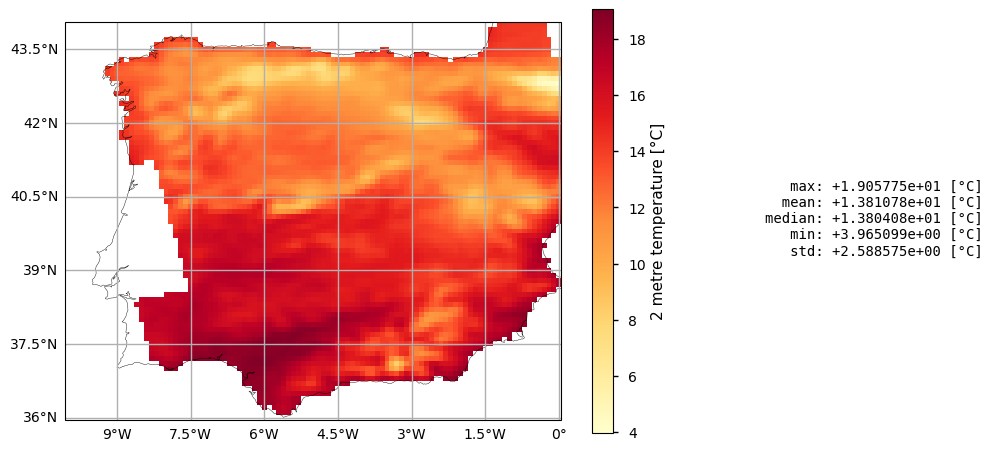

In [6]:
da_time_mean = diagnostics.time_weighted_mean(da)
plot.projected_map(
    da_time_mean.where(da_time_mean), projection=ccrs.PlateCarree(), cmap="YlOrRd"
)
_ = plt.title("")

##  Plot annual spatial mean

Calculate trend and significance with Mann Kendall Test and check for significance

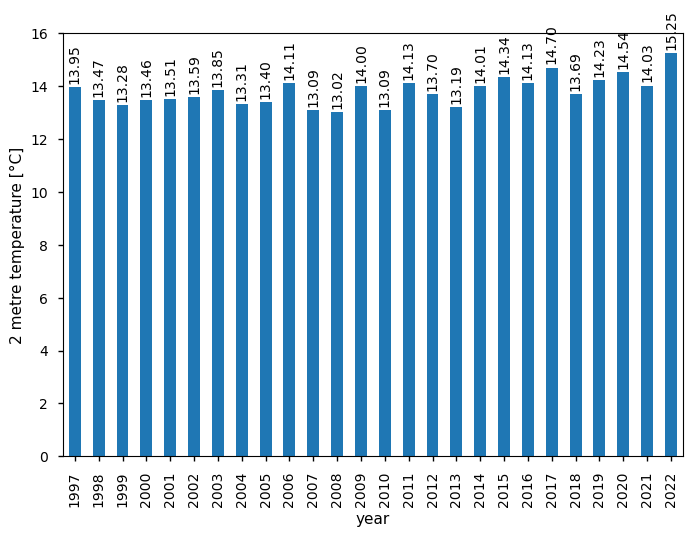

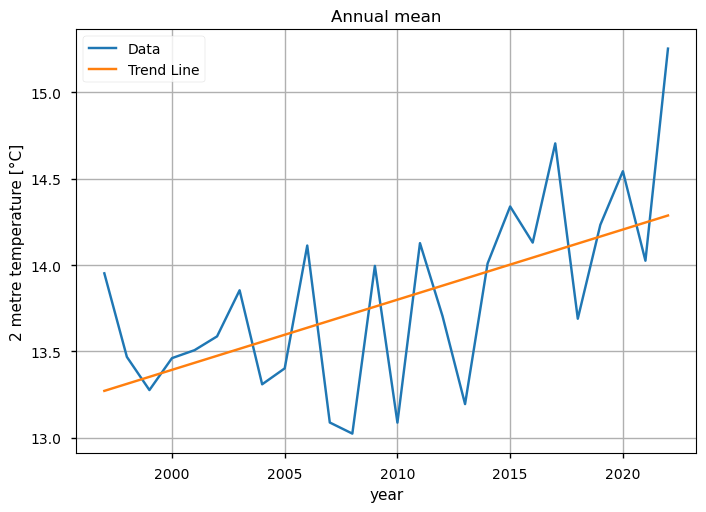

The trend is significant.
Trend: 0.040638 °C/year


In [7]:
da_spatial_mean = diagnostics.spatial_weighted_mean(da)
da_annual_mean = diagnostics.annual_weighted_mean(da_spatial_mean)
trend, h, p, z, tau, s, var_s, slope, intercept = mk.original_test(da_annual_mean)

# Plot bars
ax = da_annual_mean.to_pandas().plot.bar()
ax.set_ylabel(f"{da_annual_mean.attrs['long_name']} [{da_annual_mean.attrs['units']}]")
ax.bar_label(ax.containers[0], rotation=90, fmt="%.2f", padding=2.5)
plt.show()

# Plot lines
da_annual_mean.plot(label="Data")
plt.plot(
    da_annual_mean["year"],
    np.arange(da_annual_mean.sizes["year"]) * slope + intercept,
    label="Trend Line",
)
plt.legend()
plt.grid()
plt.title("Annual mean")
plt.show()

# Print significance
is_significant = p < 0.05
print(f"The trend is{'' if is_significant else ' NOT'} significant.")
print(f"Trend: {slope:f} {da_annual_mean.attrs['units']}/year")


## Comparison with in-situ data

The observed trend is significant.
Trend: 0.027333 °C/year
Bias: -0.4219079886234211 °C/year


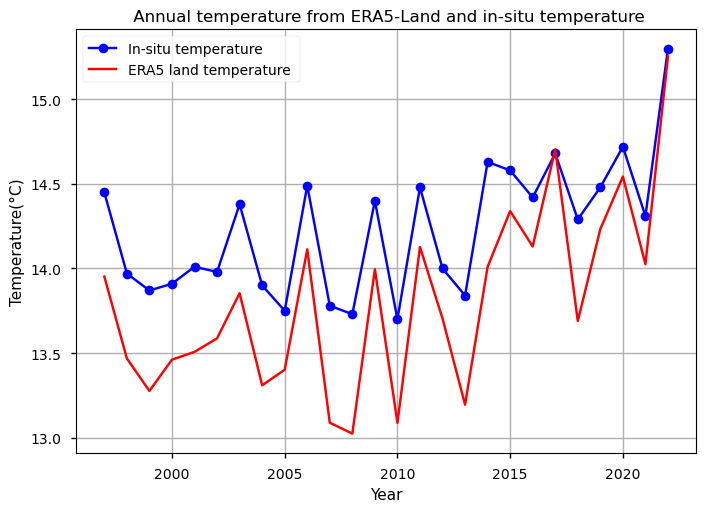

In [8]:
# Read the CSV file into a DataFrame
observed = pd.read_csv(observed_csv)
mask = (observed["Category"] >= year_start) & (observed["Category"] <= year_stop)
observed = observed[mask]

# Trend and significance
trend, h, p, z, tau, s, var_s, slope, intercept = mk.original_test(
    observed["Annual Mean"]
)
is_significant = p < 0.05
print(f"The observed trend is{'' if is_significant else ' NOT'} significant.")
print(f"Trend: {slope:f} {da_annual_mean.attrs['units']}/year")

# bias
bias = np.mean(np.array(da_annual_mean - observed["Annual Mean"]))
print(f"Bias: {bias} {da_annual_mean.attrs['units']}/year")

# Plot the first line
plt.plot(
    observed["Category"],
    observed["Annual Mean"],
    label="In-situ temperature",
    color="blue",
    marker="o",
)

# Plot the second line
plt.plot(
    da_annual_mean["year"],
    da_annual_mean,
    label="ERA5 land temperature ",
    color="red",
    marker="x",
)

# Add labels and title
plt.xlabel("Year")
plt.ylabel("Temperature(°C)")
plt.title(" Annual temperature from ERA5-Land and in-situ temperature")

# Add legend
plt.legend()
plt.grid()